In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from os import walk, path

from sklearn.metrics import roc_curve, auc

In [2]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 80,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })

In [3]:
datafile = '../data/processed/chan2b/2020-10-15-VariationalAutoEncoderBeta-0.999-8-256-256-1.0-0.0001.pkl'
with open(datafile, 'rb') as f:
    data = pickle.load(f)

In [4]:
data.keys()

dict_keys(['background_chan2b_7.8.npz', 'chacha_cha300_neut140_chan2b.npz', 'chacha_cha400_neut60_chan2b.npz', 'chacha_cha600_neut200_chan2b.npz', 'chaneut_cha200_neut50_chan2b.npz', 'chaneut_cha250_neut150_chan2b.npz', 'gluino_1000.0_neutralino_1.0_chan2b.npz', 'pp23mt_50_chan2b.npz', 'pp24mt_50_chan2b.npz', 'stlp_st1000_chan2b.npz'])

In [5]:
bkg = data['background_chan2b_7.8.npz']
sig_names = [k for k in data.keys() if 'background' not in k]
print(sig_names, len(sig_names))

['chacha_cha300_neut140_chan2b.npz', 'chacha_cha400_neut60_chan2b.npz', 'chacha_cha600_neut200_chan2b.npz', 'chaneut_cha200_neut50_chan2b.npz', 'chaneut_cha250_neut150_chan2b.npz', 'gluino_1000.0_neutralino_1.0_chan2b.npz', 'pp23mt_50_chan2b.npz', 'pp24mt_50_chan2b.npz', 'stlp_st1000_chan2b.npz'] 9


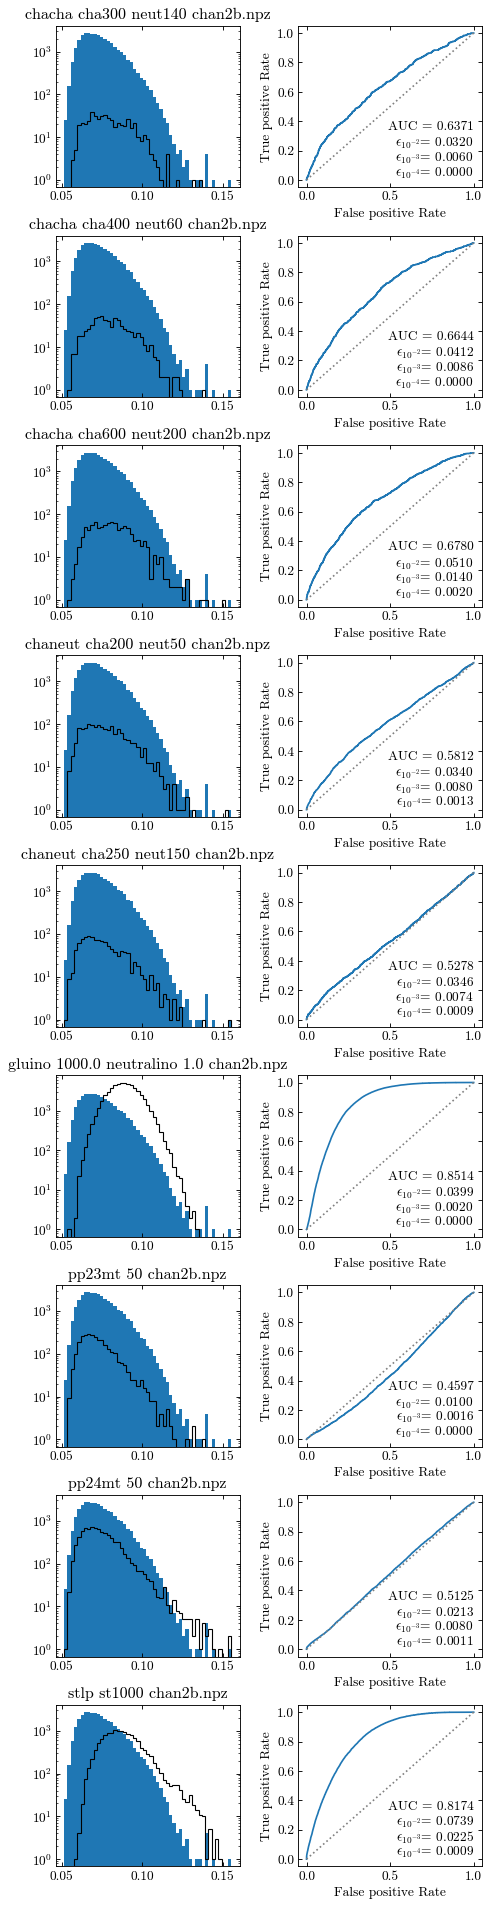

In [6]:
plt.figure(figsize=(6, 24))
for i, s in enumerate(sig_names):
    plt.subplot(len(sig_names), 2, (2 * i)+1)
    back = bkg['loss_matrix'][bkg['loss_matrix'] > 0]
    p, b, h = plt.hist(back, bins=51)
    sig = data[s]['loss_matrix']
    sig = sig[sig>0]
    plt.hist(sig, bins=b, histtype='step', color='k')
    plt.title(s.replace('_', ' '))
    plt.yscale('log')
    y_true = np.hstack([np.zeros(back.shape[0]), np.ones(sig.shape[0])])
    y_pred = np.hstack([back, sig])
    fpr, tpr, thrs = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    roc_interp = interp1d(fpr, tpr)
    plt.subplot(len(sig_names), 2, (2 * (i+1)))
    plt.plot(fpr, tpr, label=f'{auc_score:0.3f}')
    plt.plot([0, 1], [0, 1], ls=':', color='grey')
    plt.text(1, 0.4, r'AUC = ' +f'{auc_score:0.4f}', ha='right', va='top')
    plt.text(1, 0.3, r'$\epsilon_{10^{-2}}$= ' +f'{roc_interp(1e-2):0.4f}', ha='right', va='top')
    plt.text(1, 0.2, r'$\epsilon_{10^{-3}}$= ' +f'{roc_interp(1e-3):0.4f}', ha='right', va='top')
    plt.text(1, 0.1, r'$\epsilon_{10^{-4}}$= ' +f'{roc_interp(1e-4):0.4f}', ha='right', va='top')
#     plt.legend(loc='best')
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.xlim(1e-5, 2)
    plt.xlabel('False positive Rate')
    plt.ylabel('True positive Rate')
    
plt.tight_layout()
plt.show()

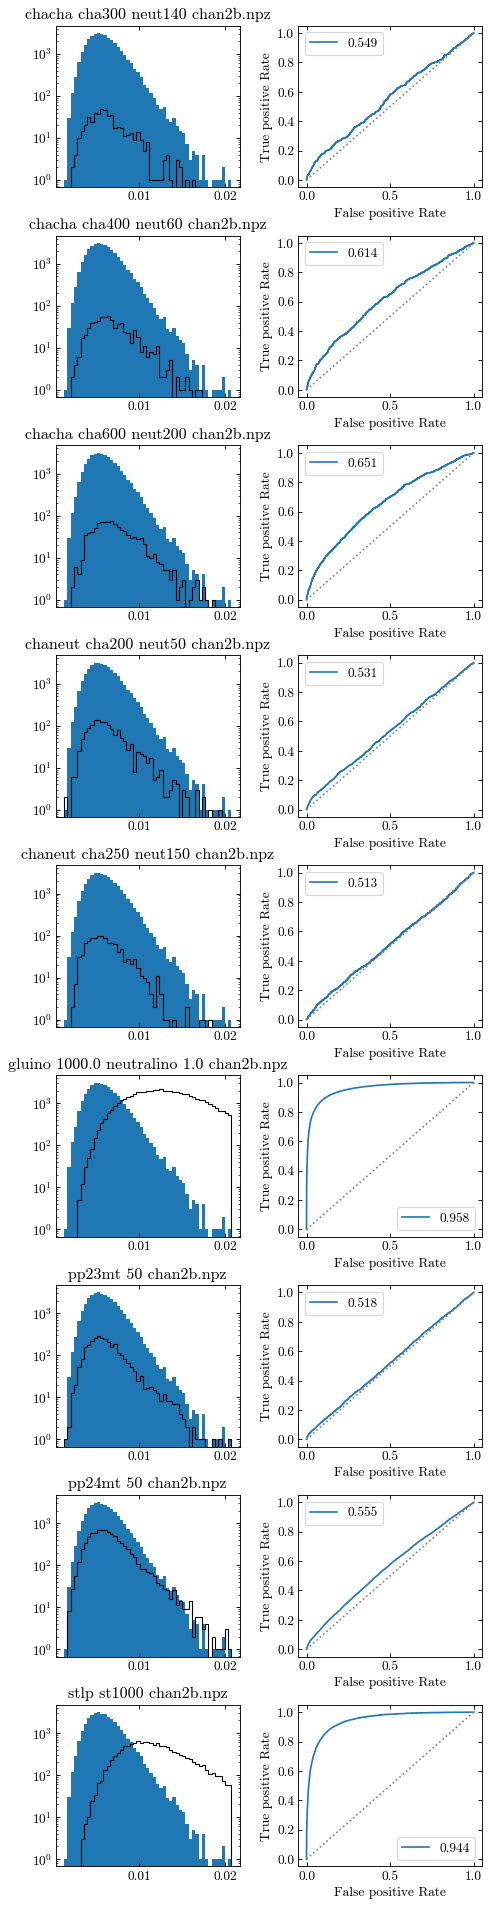

In [7]:
plt.figure(figsize=(6, 24))
for i, s in enumerate(sig_names):
    plt.subplot(len(sig_names), 2, (2 * i)+1)
    back = np.sqrt(np.sum(np.square(bkg['latent_matrix']), axis=1))
    back = back[back>0]
    sig = np.sqrt(np.sum(np.square(data[s]['latent_matrix']), axis=1))
    sig = sig[sig>0]
    p, b, h = plt.hist(back, bins=51)
    plt.hist(sig, bins=b, histtype='step', color='k')
    plt.title(s.replace('_', ' '))
    plt.yscale('log')
    
    y_true = np.hstack([np.zeros(back.shape[0]), np.ones(sig.shape[0])])
    y_pred = np.hstack([back, sig])
    fpr, tpr, thrs = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    plt.subplot(len(sig_names), 2, (2 * (i+1)))
    plt.plot(fpr, tpr, label=f'{auc_score:0.3f}')
    plt.plot([0, 1], [0, 1], ls=':', color='grey')
    plt.legend(loc='best')
#     plt.yscale('log')
    plt.xlabel('False positive Rate')
    plt.ylabel('True positive Rate')
    
plt.tight_layout()
plt.show()

# Scan

In [4]:
import os

In [5]:
model_results = os.listdir('../data/processed/chan1/')

In [6]:
results_rl = {}
results_latentdist = {}
mnames = []
AllSigs = []
for cnum, chan in enumerate(['chan1', 'chan2a', 'chan2b']):
    model_results = os.listdir(f'../data/processed/{chan}/')
    print(chan)
    for i, model in enumerate(model_results):
        
        datafile = f'../data/processed/{chan}/{model}'
        beta=float(model.split('-8-')[0].split('-')[-1])
        if beta == 6:
            beta=1e-6
        Weight=float(model.split('-')[-2])
        mname=f'Beta_{beta}_W_{Weight}'
        mnames.append(mname)
        print(mname)
        try:
            with open(datafile, 'rb') as f:
                data = pickle.load(f)
            sig_names = [k for k in data.keys() if 'background' not in k]
            if (i == 0) :
                AllSigs += sig_names
                print(AllSigs)
            bkgname = [k for k in data.keys() if 'background' in k][0]
        #     print(sig_names)
            if i == 0:
                for sig in sig_names:

                    results_rl[sig] = {}
                    results_latentdist[sig] = {}
                    

            # *******************
            # Loss
            # *******************
            bkg = data[bkgname]
            back = bkg['loss_matrix'][bkg['loss_matrix'] > 0]
            for sig in sig_names:
                signal = data[sig]['loss_matrix']
                signal = signal[signal>0]

                y_true = np.hstack([np.zeros(back.shape[0]), np.ones(signal.shape[0])])
                y_pred = np.hstack([back, signal])
                fpr, tpr, thrs = roc_curve(y_true, y_pred)
                auc_score = auc(fpr, tpr)
                roc_interp = interp1d(fpr, tpr)

                results_rl[sig][mname] = {
                    'Anomaly Score': 'Loss',
                    'Beta': beta,
                    'Weight': Weight,
                    'AUC': auc_score,
                    '1e-2': roc_interp(1e-2),
                    '1e-3': roc_interp(1e-3),
                    '1e-4': roc_interp(1e-4),
                    'tpr':tpr,
                    'fpr':fpr,
                    'sig': signal,
                    'bkg': back
                }
        except pickle.UnpicklingError as e:
            # normal, somewhat expected
            continue
    

        # *******************
        # Latent Distance
        # *******************
    #     bkg = data[bkgname]['latent_matrix']
    #     bkg = np.sqrt(np.sum(np.square(bkg), axis=1))
    #     back = bkg[bkg > 0]
    #     for sig in sig_names:
    #         signal = data[sig]['latent_matrix']
    #         signal = np.sqrt(np.sum(np.square(signal), axis=1))
    #         signal = signal[signal>0]

    #         y_true = np.hstack([np.zeros(back.shape[0]), np.ones(signal.shape[0])])
    #         y_pred = np.hstack([back, signal])
    #         fpr, tpr, thrs = roc_curve(y_true, y_pred)
    #         auc_score = auc(fpr, tpr)
    #         roc_interp = interp1d(fpr, tpr)

    #         results_latentdist[sig][mname] = {
    #             'Anomaly Score': 'Latent Distance',
    #             'Beta': beta,
    #             'Weight': Weight,
    #             'AUC': auc_score,
    #             '1e-2': roc_interp(1e-2),
    #             '1e-3': roc_interp(1e-3),
    #             '1e-4': roc_interp(1e-4)
    #         }


chan1
Beta_0.5_W_0.1
['glgl1400_neutralino1100_chan1.npz', 'glgl1600_neutralino800_chan1.npz', 'monojet_Zp2000.0_DM_50.0_chan1.npz', 'monotop_200_A_chan1.npz', 'sqsq1_sq1400_neut800_chan1.npz', 'sqsq_sq1800_neut800_chan1.npz', 'stlp_st1000_chan1.npz', 'stop2b1000_neutralino300_chan1.npz']
Beta_0.1_W_1.0
Beta_0.999_W_100.0
Beta_0.8_W_10.0
Beta_0.001_W_1.0
Beta_0.5_W_10.0
Beta_0.8_W_0.1
Beta_1.0_W_0.1
Beta_0.1_W_100.0
Beta_1e-06_W_0.1
Beta_1e-06_W_10.0
Beta_0.999_W_0.1
Beta_0.999_W_1.0
Beta_0.5_W_1.0
Beta_1.0_W_1.0
Beta_0.999_W_10.0
Beta_1.0_W_100.0
Beta_1e-06_W_100.0
Beta_0.001_W_0.1
Beta_0.001_W_10.0
Beta_0.1_W_0.1
Beta_0.001_W_100.0
Beta_0.5_W_100.0
Beta_0.1_W_10.0
Beta_0.8_W_1.0
Beta_0.8_W_100.0
Beta_1.0_W_10.0
Beta_1e-06_W_1.0
chan2a
Beta_0.8_W_1.0
['glgl1400_neutralino1100_chan1.npz', 'glgl1600_neutralino800_chan1.npz', 'monojet_Zp2000.0_DM_50.0_chan1.npz', 'monotop_200_A_chan1.npz', 'sqsq1_sq1400_neut800_chan1.npz', 'sqsq_sq1800_neut800_chan1.npz', 'stlp_st1000_chan1.npz', 'stop2b

In [7]:
mysummary = pd.DataFrame()

for sig in AllSigs:
    df1 = pd.DataFrame.from_dict(results_rl[sig], orient='index')
#     print(df1)
#     df2 = pd.DataFrame.from_dict(results_latentdist[sig], orient='index')
    dfc = df1  #.append(df2)
    dfc.index = (dfc.index + '_' + dfc['Anomaly Score'])
    mysummary[sig]=(-1*dfc['AUC']).argsort()
    print(dfc.shape)
# mysummary['sum'] = mysummary.sum(axis=1)

# mysummary['best'] = (mysummary[[col for col in mysummary.columns if 'sum' not in col]] < 1).sum(axis=1)
# mysummary['top5'] = (mysummary[[col for col in mysummary.columns if (('sum' not in col) and 
#                                                                      ('best' not in col))]] < 5).sum(axis=1)
# mysummary['top10'] = (mysummary[[col for col in mysummary.columns if (('sum' not in col) and 
#                                                                       ('best' not in col) and
#                                                                       ('top5' not in col)
#                                                                      )
#                                 ]] < 10).sum(axis=1)


(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)
(28, 11)


In [8]:
mysummary

,glgl1400_neutralino1100_chan1.npz,glgl1600_neutralino800_chan1.npz,monojet_Zp2000.0_DM_50.0_chan1.npz,monotop_200_A_chan1.npz,sqsq1_sq1400_neut800_chan1.npz,sqsq_sq1800_neut800_chan1.npz,stlp_st1000_chan1.npz,stop2b1000_neutralino300_chan1.npz,chaneut_cha200_neut50_chan2a.npz,chaneut_cha250_neut150_chan2a.npz,...,pp24mt_50_chan2a.npz,chacha_cha300_neut140_chan2b.npz,chacha_cha400_neut60_chan2b.npz,chacha_cha600_neut200_chan2b.npz,chaneut_cha200_neut50_chan2b.npz,chaneut_cha250_neut150_chan2b.npz,gluino_1000.0_neutralino_1.0_chan2b.npz,pp23mt_50_chan2b.npz,pp24mt_50_chan2b.npz,stlp_st1000_chan2b.npz
Beta_0.5_W_0.1_Loss,20,16,0,13,13,16,14,13,24,25,...,9,21,9,21,25,1,22,2,4,6
Beta_0.1_W_1.0_Loss,0,0,16,14,10,26,7,1,23,7,...,12,15,17,7,7,8,4,21,22,23
Beta_0.999_W_100.0_Loss,18,20,26,26,20,14,26,23,4,2,...,14,26,26,4,12,23,16,17,25,0
Beta_0.8_W_10.0_Loss,9,26,20,16,25,7,16,3,10,10,...,17,3,3,10,24,14,14,15,15,15
Beta_0.001_W_1.0_Loss,4,14,7,7,1,0,13,17,2,12,...,24,8,23,16,4,10,17,23,1,11
Beta_0.5_W_10.0_Loss,13,18,13,0,23,20,17,8,6,18,...,18,17,18,15,17,15,23,10,21,14
Beta_0.8_W_0.1_Loss,10,9,18,17,16,18,8,14,3,4,...,25,9,24,24,23,3,26,13,26,24
Beta_1.0_W_0.1_Loss,1,13,14,18,27,13,21,5,22,6,...,10,12,5,5,11,22,1,5,13,16
Beta_0.1_W_100.0_Loss,27,1,9,9,5,9,23,21,14,13,...,3,7,13,13,1,25,19,9,2,25
Beta_1e-06_W_0.1_Loss,25,7,1,1,19,1,25,25,11,21,...,1,27,4,11,19,4,27,14,6,10


In [9]:
mysummary.index

Index(['Beta_0.5_W_0.1_Loss', 'Beta_0.1_W_1.0_Loss', 'Beta_0.999_W_100.0_Loss',
       'Beta_0.8_W_10.0_Loss', 'Beta_0.001_W_1.0_Loss', 'Beta_0.5_W_10.0_Loss',
       'Beta_0.8_W_0.1_Loss', 'Beta_1.0_W_0.1_Loss', 'Beta_0.1_W_100.0_Loss',
       'Beta_1e-06_W_0.1_Loss', 'Beta_1e-06_W_10.0_Loss',
       'Beta_0.999_W_0.1_Loss', 'Beta_0.999_W_1.0_Loss', 'Beta_0.5_W_1.0_Loss',
       'Beta_1.0_W_1.0_Loss', 'Beta_0.999_W_10.0_Loss',
       'Beta_1.0_W_100.0_Loss', 'Beta_1e-06_W_100.0_Loss',
       'Beta_0.001_W_0.1_Loss', 'Beta_0.001_W_10.0_Loss',
       'Beta_0.1_W_0.1_Loss', 'Beta_0.001_W_100.0_Loss',
       'Beta_0.5_W_100.0_Loss', 'Beta_0.1_W_10.0_Loss', 'Beta_0.8_W_1.0_Loss',
       'Beta_0.8_W_100.0_Loss', 'Beta_1.0_W_10.0_Loss',
       'Beta_1e-06_W_1.0_Loss'],
      dtype='object')

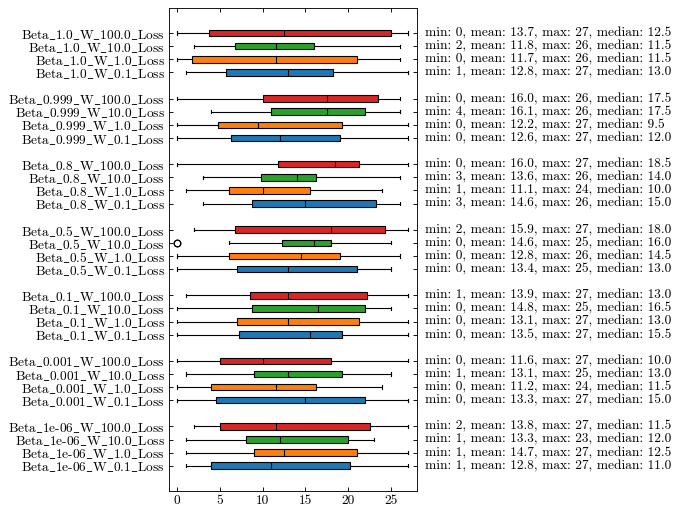

In [10]:
plt.figure(figsize=(4,8))
data_bplot=[]
yvs=[]
names = []
for i, beta in enumerate(['1e-06', '0.001', '0.1', '0.5', '0.8', '0.999', '1.0']):
    for j, mult in enumerate(['0.1', '1.0', '10.0', '100.0']):
        data_bplot.append(mysummary.loc[f'Beta_{beta}_W_{mult}_Loss'].to_numpy())
        yvs.append(i*5 + j)
        names.append(f'Beta_{beta}_W_{mult}_Loss')
data_bplot = np.array(data_bplot)

bbox1 = plt.boxplot(data_bplot.T,
                    vert=False,
                    manage_ticks=False,
                    patch_artist=True,
                    medianprops={'color':'k'},
                    positions=yvs
                   )
colors = ['C0', 'C1', 'C2', 'C3'] * 9  #, 'lightgreen']
for patch, color in zip(bbox1['boxes'], colors):
    patch.set_facecolor(color)

for i, yv in zip(range(len(yvs)), yvs):
    plt.text(29, yv, f'min: {np.min(data_bplot[i])}, mean: {np.mean(data_bplot[i]):1.1f}, max: {np.max(data_bplot[i])}, median: {np.median(data_bplot[i])}',
             ha='left',
             va='center'
            )
    
plt.xlim(-1, 28)
plt.yticks(yvs, [n.replace('_', r'$\_$') for n in names])

plt.show()

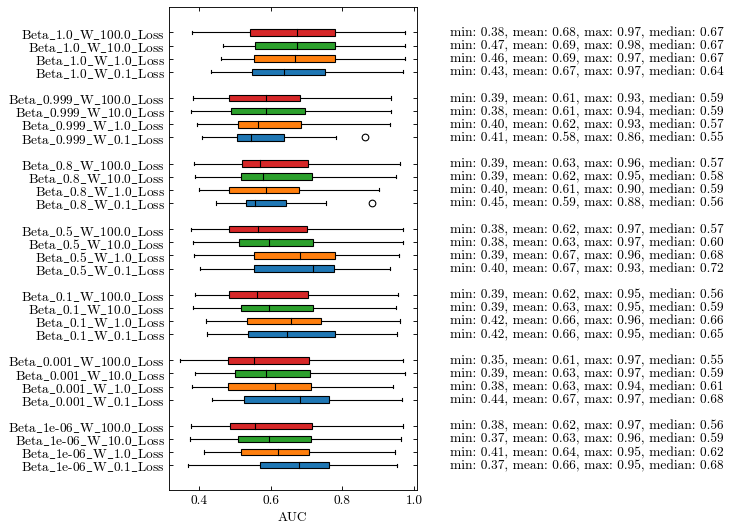

In [11]:
plt.figure(figsize=(4,8))
data_bplot=[]
yvs=[]
names = []
for i, beta in enumerate(['1e-06', '0.001', '0.1', '0.5', '0.8', '0.999', '1.0']):
    for j, mult in enumerate(['0.1', '1.0', '10.0', '100.0']):
        aucs = []
        for sig in AllSigs:
            aucs.append(results_rl[sig][f'Beta_{beta}_W_{mult}']['AUC'])
        data_bplot.append(aucs)
        yvs.append(i*5 + j)
        names.append(f'Beta_{beta}_W_{mult}_Loss')
data_bplot = np.array(data_bplot)

bbox1 = plt.boxplot(data_bplot.T,
                    vert=False,
                    manage_ticks=False,
                    patch_artist=True,
                    medianprops={'color':'k'},
                    positions=yvs
                   )
colors = ['C0', 'C1', 'C2', 'C3'] * 9  #, 'lightgreen']
for patch, color in zip(bbox1['boxes'], colors):
    patch.set_facecolor(color)

for i, yv in zip(range(len(yvs)), yvs):
    plt.text(1.1, yv, f'min: {np.min(data_bplot[i]):0.2f}, mean: {np.mean(data_bplot[i]):0.2f}, max: {np.max(data_bplot[i]):0.2f}, median: {np.median(data_bplot[i]):0.2f}',
             ha='left',
             va='center'
            )
    
# plt.xlim(-1, 28)
plt.yticks(yvs, [n.replace('_', r'$\_$') for n in names])
plt.xlabel('AUC')

plt.show()

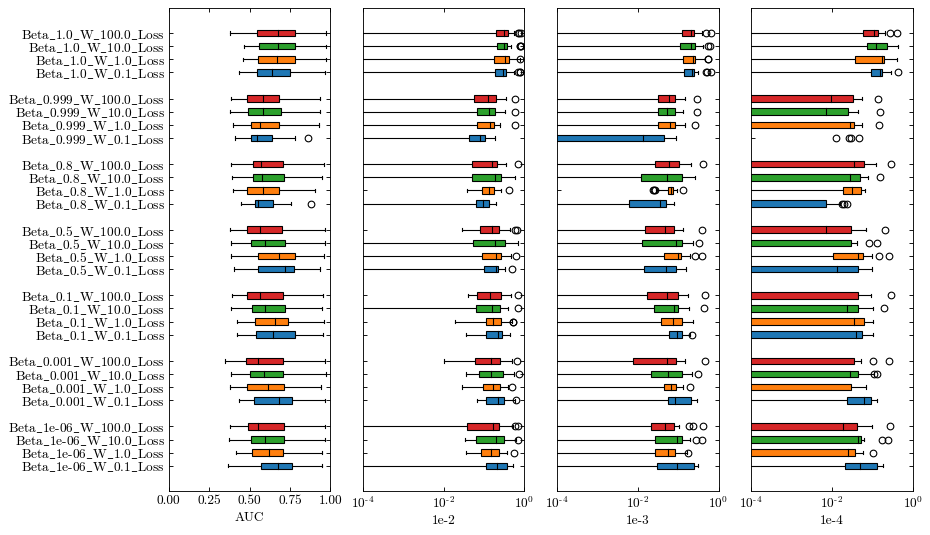

In [12]:
plt.figure(figsize=(12,8))

for colnum, col in enumerate(['AUC', '1e-2', '1e-3', '1e-4']):
    plt.subplot(1, 4, colnum + 1)
    data_bplot=[]
    yvs=[]
    names = []
    for i, beta in enumerate(['1e-06', '0.001', '0.1', '0.5', '0.8', '0.999', '1.0']):
        for j, mult in enumerate(['0.1', '1.0', '10.0', '100.0']):
            dataind = []
            for sig in AllSigs:
                if col=='AUC':
                    dataind.append(results_rl[sig][f'Beta_{beta}_W_{mult}'][col])
                else:
                    es = results_rl[sig][f'Beta_{beta}_W_{mult}'][col]
                    dataind.append(es / np.sqrt(es + float(col)))
            data_bplot.append(dataind)
            yvs.append(i*5 + j)
            names.append(f'Beta_{beta}_W_{mult}_Loss')
    data_bplot = np.array(data_bplot)

    bbox1 = plt.boxplot(data_bplot.T,
                        vert=False,
                        manage_ticks=False,
                        patch_artist=True,
                        medianprops={'color':'k'},
                        positions=yvs
                       )
    colors = ['C0', 'C1', 'C2', 'C3'] * 9  #, 'lightgreen']
    for patch, color in zip(bbox1['boxes'], colors):
        patch.set_facecolor(color)

    # for i, yv in zip(range(len(yvs)), yvs):
    #     plt.text(1.1, yv, f'min: {np.min(data_bplot[i]):0.2f}, mean: {np.mean(data_bplot[i]):0.2f}, max: {np.max(data_bplot[i]):0.2f}, median: {np.median(data_bplot[i]):0.2f}',
    #              ha='left',
    #              va='center'
    #             )

    # plt.xlim(-1, 28)
    
    if colnum == 0:
        plt.yticks(yvs, [n.replace('_', r'$\_$') for n in names])
        plt.xlim(0, 1)
    else:
        plt.yticks(yvs, [])
        plt.xscale('log')
        plt.xlim(1e-4, 1)
    plt.xlabel(col)
# plt.savefig('../reports/figures/ModelComparisonBoxPlot.pdf', bbox_incehs='tight')
plt.show()

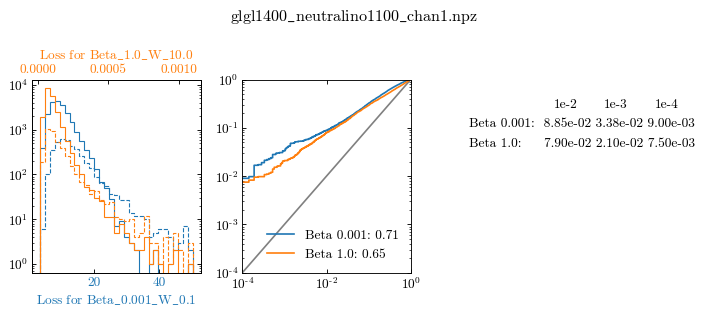

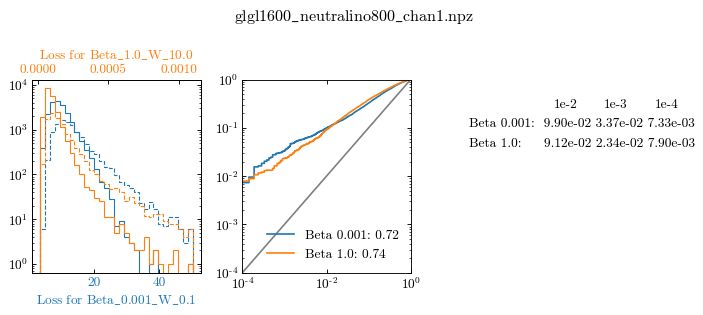

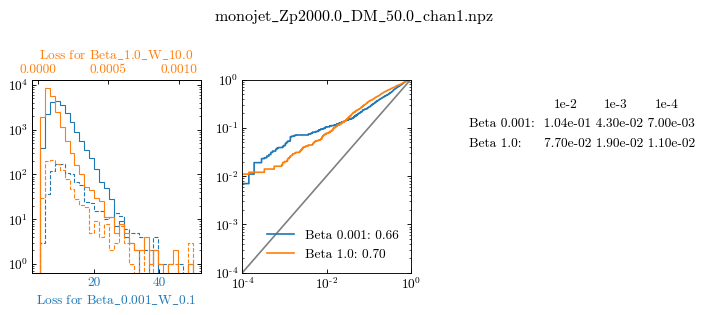

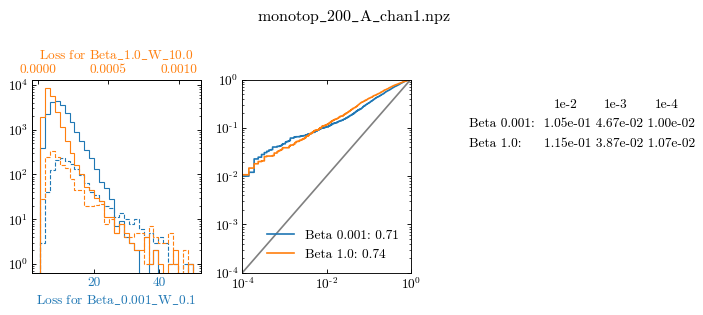

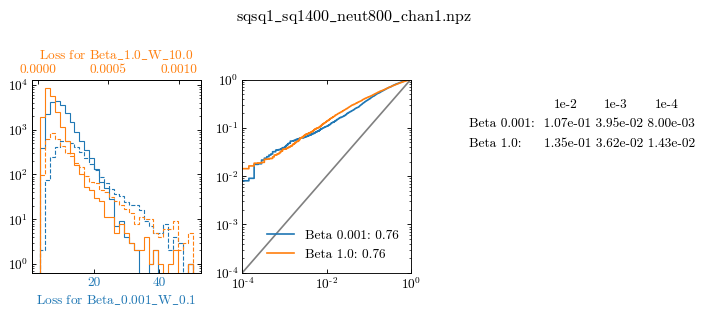

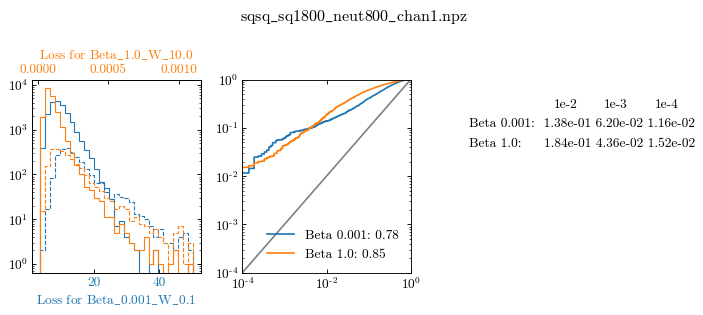

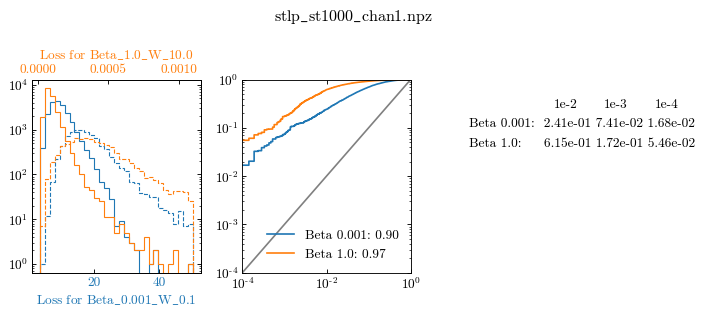

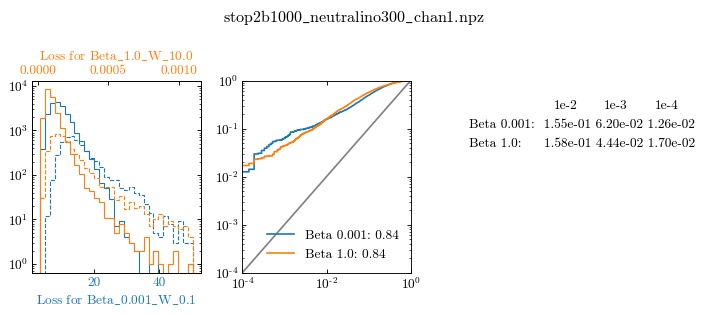

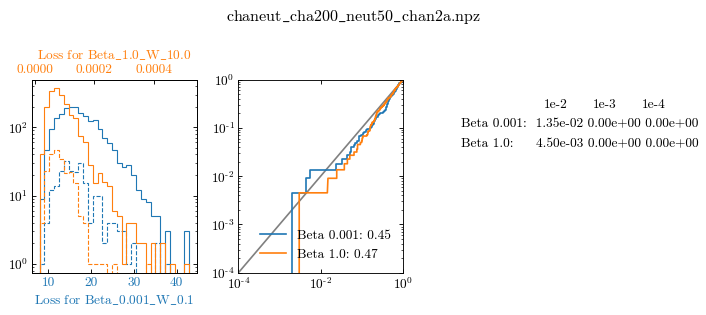

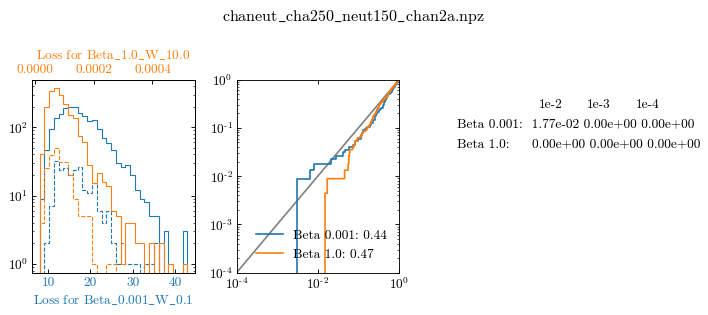

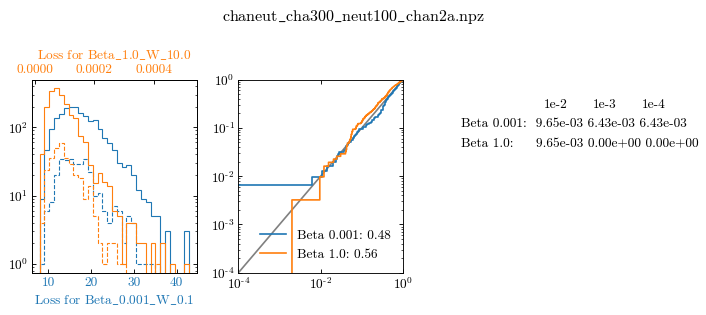

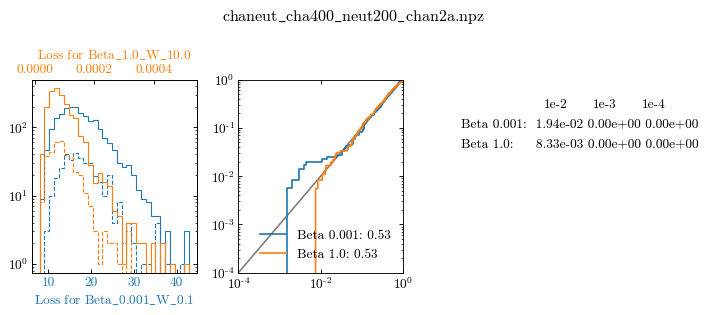

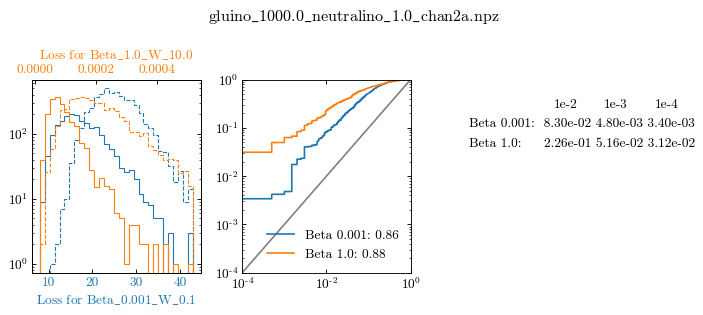

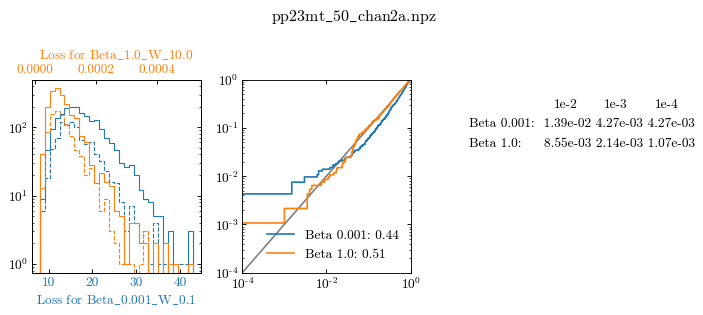

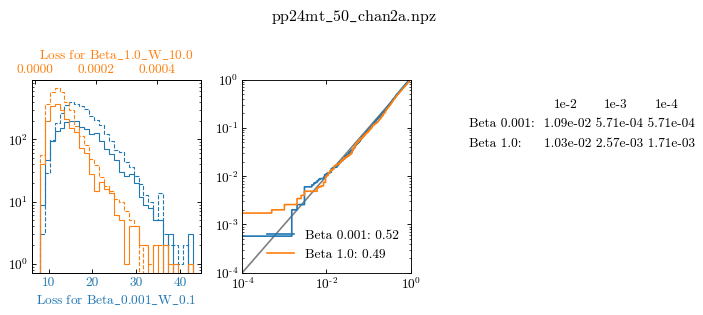

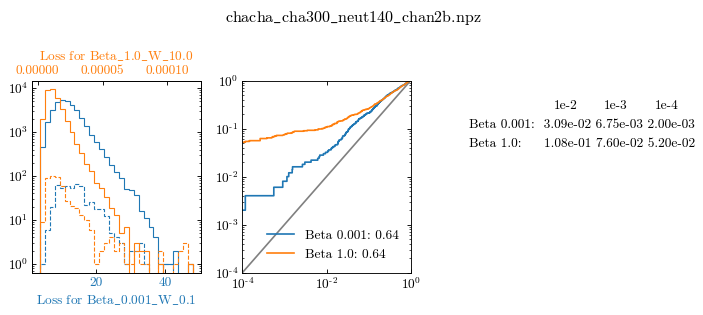

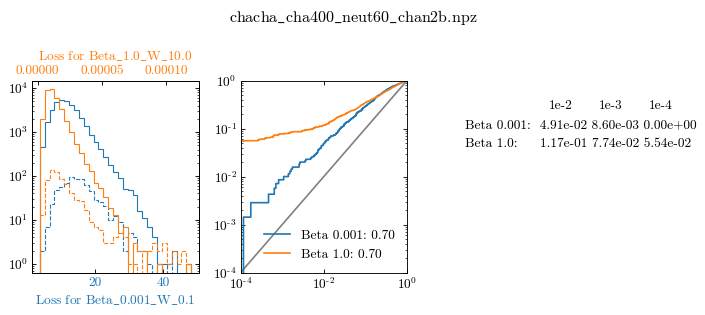

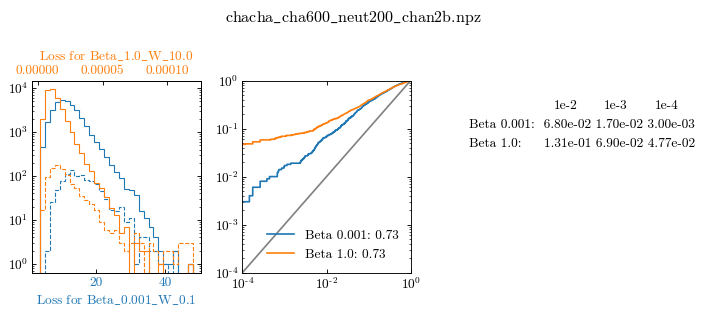

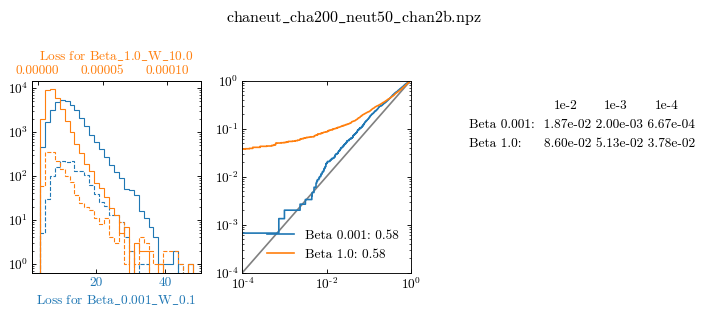

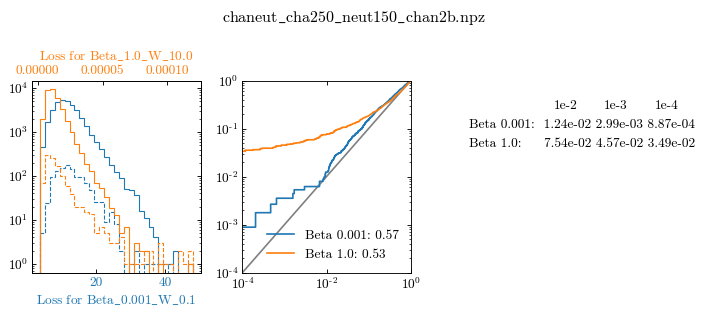

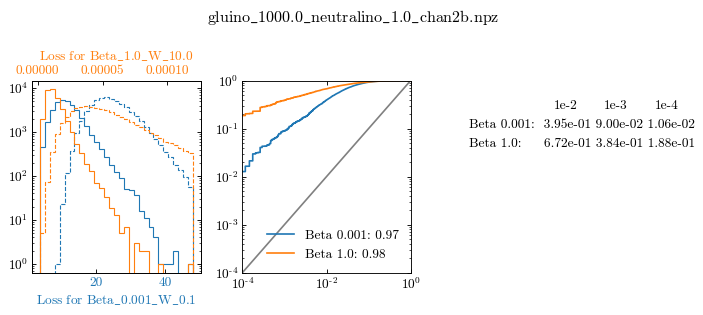

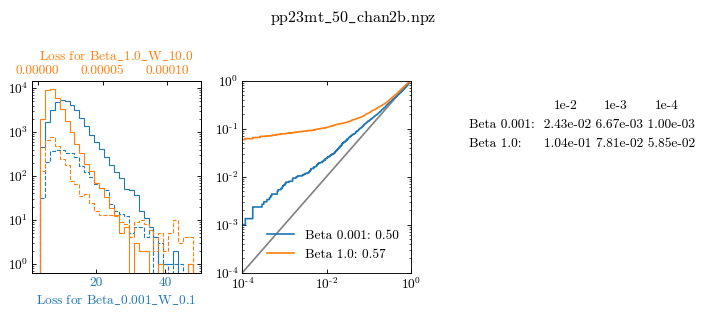

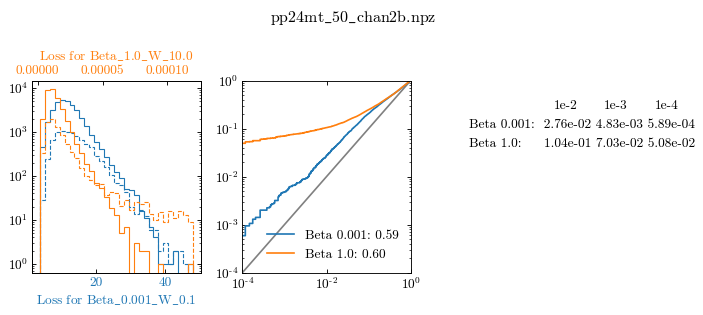

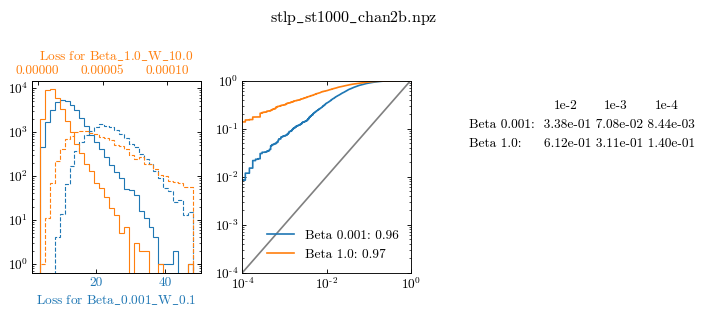

In [17]:
mname2 = f'Beta_1.0_W_10.0'
mname1 = f'Beta_0.001_W_0.1'
for i, sig in enumerate(AllSigs):
    plt.figure(figsize=(9,4))
    
    ax0 = plt.subplot(1, 3, 1)
    n, b, _ = ax0.hist(results_rl[sig][mname1]['bkg'], bins=31, histtype='step', color='C0')
    ax0.hist(results_rl[sig][mname1]['sig'], bins=b, histtype='step', color='C0', ls='--')
    ax0.set_xlabel('Loss for ' + mname1.replace('_', r'$\_$'), color='C0')
    ax0.tick_params(axis='x', labelcolor='C0')
    plt.yscale('log')
    
    ax2 = ax0.twiny()
    n, b, _ = ax2.hist(results_rl[sig][mname2]['bkg'], bins=31, histtype='step', color='C1')
    ax2.hist(results_rl[sig][mname2]['sig'], bins=b, histtype='step', color='C1', ls='--')
    plt.yscale('log')
    ax2.set_xlabel('Loss for ' + mname2.replace('_', r'$\_$'), color='C1')
    ax2.tick_params(axis='x', labelcolor='C1')
    
    
    plt.subplot(1, 3, 2)
    plt.plot([1e-5,1], [1e-5, 1], color='grey')
    plt.plot(results_rl[sig][mname1]['fpr'], results_rl[sig][mname1]['tpr'],
             label=f"{r'Beta ' + str(results_rl[sig][mname1]['Beta'])}: {results_rl[sig][mname1]['AUC']:0.2f}")
    plt.plot(results_rl[sig][mname2]['fpr'], results_rl[sig][mname2]['tpr'],
             label=f"{r'Beta ' + str(results_rl[sig][mname2]['Beta'])}: {results_rl[sig][mname2]['AUC']:0.2f}")
    plt.legend(loc='lower right', frameon=False)
    plt.xlim(1e-4, 1)
    plt.ylim(1e-4, 1)
    plt.xscale('log')
    plt.yscale('log')
    
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0.1, 0.8, f"{r'Beta ' + str(results_rl[sig][mname1]['Beta'])}:  {results_rl[sig][mname1]['1e-2']:0.2e} {results_rl[sig][mname1]['1e-3']:0.2e} {results_rl[sig][mname1]['1e-4']:0.2e}",
             ha='left', va='top'
            )
    plt.text(0.1, 0.7, f"{r'Beta ' + str(results_rl[sig][mname2]['Beta'])}:     {results_rl[sig][mname2]['1e-2']:0.2e} {results_rl[sig][mname2]['1e-3']:0.2e} {results_rl[sig][mname2]['1e-4']:0.2e}",
             ha='left', va='top'
            )
    plt.text(0.6, 0.9, "1e-2", ha='left', va='top')
    plt.text(0.9, 0.9, "1e-3", ha='left', va='top')
    plt.text(1.2, 0.9, "1e-4", ha='left', va='top')
    
    plt.suptitle(sig.replace('_', r'$\_$'))
    plt.tight_layout()
    plt.savefig(f"../reports/figures/{sig.split('_')[-1].split('.')[0]}/{sig[:-4]}.pdf", bbox_inches='tight')
    plt.show()

In [124]:
plt.hist?

In [ ]:
for result_name in mysorted.index[:10]:
    PrintResults = [['Beta', 'Weight', 'Signal', 'AnomalyScore', 'AUC', '1e-2', '1e-3', '1e-4']]
    for sig in sig_names:
        if 'Loss' in result_name:
            df1 = pd.DataFrame.from_dict(results_rl[sig], orient='index')
            tmp = df1.loc[result_name[:-5]]
            PrintResults.append([tmp['Beta'], tmp['Weight'], sig[:-4], 'Loss', tmp['AUC'], tmp['1e-2'], tmp['1e-3'], tmp['1e-4']])
    print(pd.DataFrame(PrintResults[1:], columns=PrintResults[0]).to_latex(index=False))
#     tmp[tmp['Anomaly Score'] == 'Loss']
#     print(tmp)
#     break

In [ ]:
print(pd.DataFrame(PrintResults[1:], columns=PrintResults[0]).to_latex(index=False, float_format="%.2e"))

In [ ]:
mysorted.index[:10]